# Chapter9. 在Web应用中嵌入机器学习模型
- 保存训练后的机器学习模型的状态
- 使用SQLite数据库存储数据
- 使用Flask框架开发Web应用程序
- 在公共Web服务器上部署机器学习应用

下面是第8章的代码：

In [7]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/tuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

In [10]:
next(stream_docs(path='./movie_data.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

In [11]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [14]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path='./movie_data.csv')

In [15]:
import pyprind
pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:19


In [16]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.867


In [17]:
clf = clf.partial_fit(X_test, y_test)

## 1. 序列化使用sklearn拟合的模型
训练机器学习模型会带来很高的计算成本，我们不希望每次预测都要打开新的Python环境重新训练模型。使用pickle模块可以进行模型的持久化，它使得我们可以在Python对象和字节码之间进行转换（序列化和反序列化），这样就可以把分类器的状态保存下来。

In [18]:
import pickle
import os

# 设置路径，两个参数是嵌套的路径关系
dest = os.path.join('movieclassifier', 'pkl_objects')
if not os.path.exists(dest):
    # 路径不存在则创建
    os.makedirs(dest)
    
pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

然后，将HashingVectorizer保存到一个单独的脚本文件中，这样可以通过这个脚本将向量数据导入到当前的Python环境中。

In [19]:
%%writefile movieclassifier/vectorizer.py
from sklearn.feature_extraction.text import HashingVectorizer
import re
import os
import pickle

cur_dir = os.path.dirname(__file__)
stop = pickle.load(open(os.path.join(cur_dir,
                                     'pkl_objects',
                                     'stopwords.pkl'), 'rb'))

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) \
                   + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

Writing movieclassifier/vectorizer.py


然后，重新启动一下当前的kernel，以确保序列化正确。

In [1]:
import os
os.chdir('movieclassifier')

In [2]:
import pickle
import re
import os
from vectorizer import vect

# 加载之前保存的分类器
clf = pickle.load(open(os.path.join('pkl_objects', 'classifier.pkl'), 'rb'))

In [3]:
import numpy as np
label = {0:'negative', 1:'positive'}

example = ['I love this movie']
X = vect.transform(example)
print("Prediction: %s\nProbability: %.2f%%" %\
      (label[clf.predict(X)[0]], clf.predict_proba(X).max() * 100))

Prediction: positive
Probability: 82.52%


通过上面的验证，我们的序列化是成功的。

## 2. 使用SQLite数据库存储数据


In [5]:
# 确认在movieclassifier目录下
pwd

'/home/tuser/Program/Python/ML/PythonML/ch09/movieclassifier'

In [6]:
# 在movieclassifier目录创建一个小型的SQLite数据库
import sqlite3
import os

# 数据库如果已经存在，删除重建
if os.path.exists('reviews.sqlite'):
    os.remove('reviews.sqlite')

# 创建数据库
conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()
c.execute('CREATE TABLE review_db (review TEXT, sentiment INTEGER, date TEXT)')

# 向数据库中添加两个样本
example1 = 'I love this movie'
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example1, 1))

example2 = 'I disliked this movie'
c.execute("INSERT INTO review_db (review, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example2, 0))

# 提交
conn.commit()
conn.close()

In [7]:
conn = sqlite3.connect('reviews.sqlite')
c = conn.cursor()

# 查询
c.execute("SELECT * FROM review_db WHERE date BETWEEN '2015-01-01 10:10:10' AND DATETIME('now')")
results = c.fetchall()

conn.close()

In [8]:
print(results)

[('I love this movie', 1, '2018-10-18 01:10:20'), ('I disliked this movie', 0, '2018-10-18 01:10:20')]


## 3. 使用Flask开发Web应用
在Flask中嵌入分类器

### a. 第一个Flask应用

In [12]:
os.chdir('..')

In [13]:
pwd

'/home/tuser/Program/Python/ML/PythonML/ch09'

In [14]:
cat 1st_flask_app_1/app.py

from flask import Flask, render_template

app = Flask(__name__)


@app.route('/')
def index():
    return render_template('first_app.html')


if __name__ == '__main__':
    app.run()


In [15]:
cat 1st_flask_app_1/templates/first_app.html

<!doctype html>
<html>
<head>
    <title>First app</title>
</head>
<body>
<div>Hi, this is my first Flask Web app!</div>
</body>
</html>

运行app.py，将会打开一个网页，这就是我们的Flask app

### b. 表单验证及渲染
新建一个Flask应用，按照如下目录构建：
    
    1st_flask_app_2/
       app.py
       static/
           style.css
       templates/
           _formhelpers.html
           first_app.html
           hello.html

In [16]:
pwd

'/home/tuser/Program/Python/ML/PythonML/ch09'

In [17]:
# 创建启动程序，设置debug=True，用来调试
cat 1st_flask_app_2/app.py

from flask import Flask, render_template, request
from wtforms import Form, TextAreaField, validators

app = Flask(__name__)

class HelloForm(Form):
    sayhello = TextAreaField('', [validators.DataRequired()])

@app.route('/')
def index():
    form = HelloForm(request.form)
    return render_template('first_app.html', form=form)

@app.route('/hello', methods=['POST'])
def hello():
    form = HelloForm(request.form)
    if request.method == 'POST' and form.validate():
        name = request.form['sayhello']
        return render_template('hello.html', name=name)
    return render_template('first_app.html', form=form)


if __name__ == '__main__':
    app.run(debug=True)


In [18]:
# 通过Jinja2模板引擎，在_formhelpers.html中实现一个通用宏，后续用来渲染文本域
cat 1st_flask_app_2/templates/_formhelpers.html

{% macro render_field(field) %}
    <dt>{{ field.label }}
    <dd>{{ field(**kwargs)|safe }}
    {% if field.errors %}
        <ul class=errors>
            {% for error in field.errors %}
                <li>{{ error }}</li>
            {% endfor %}
        </ul>
    {% endif %}
    </dd>
    </dt>
{% endmacro %}

In [19]:
# 最简单层叠样式表，只修改字体
cat 1st_flask_app_2/static/style.css

body {
    font-size: 2em;
}

In [23]:
# 显示用于输入的文本框
!cat 1st_flask_app_2/templates/first_app.html

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN"
        "http://www.w3.org/TR/html4/loose.dtd">
<html>
<head>
    <title>First app</title>
    <link rel="stylesheet" href="{{ url_for('static', filename='style.css') }}">
</head>
<body>
{% from "_formhelpers.html" import render_field %}

<div>What's your name?</div>
<form method=post action="/hello">
    <dl>
        {{ render_field(form.sayhello) }}
    </dl>
    <input type=submit value='Say Hello' name='submit_btn'>
</form>
</body>
</html>

## 4. 将电影分类器嵌入Web应用
我们先开发一个Web应用，此应用会提示用户输入一个电影评论，如下图：

In [25]:
pwd

'/home/tuser/Program/Python/ML/PythonML/ch09'

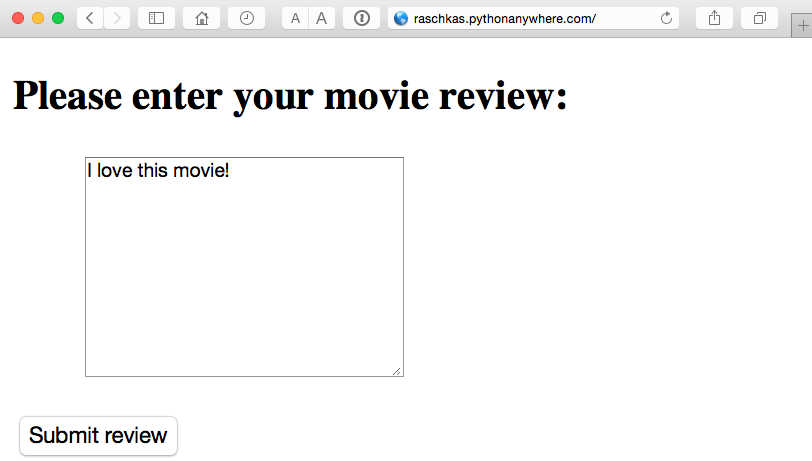

In [27]:
from IPython.display import Image
Image(filename='./images/09_04.png', width=500)

评论提交后，会返回一个新的页面，页面中会显示预测类标及评论属于此类标的概率，用户还可以反馈正确或者不正确，分类器将据此进行更新，对用户输入的文本，我们还将使用SQLite数据库进行保存。

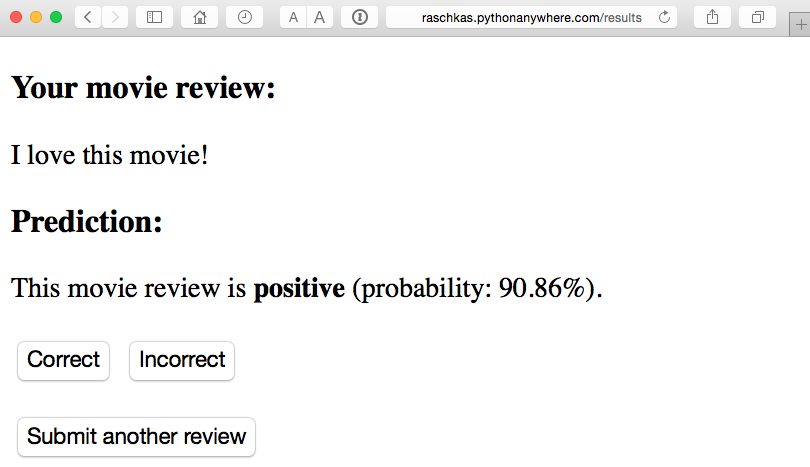

In [28]:
Image(filename='./images/09_05.png', width=500)

下面是这个应用的目录架构：

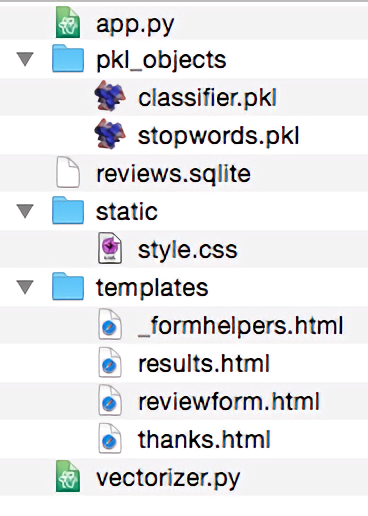

In [31]:
Image(filename='./images/09_07.png', width=200)

In [32]:
!cat ./movieclassifier/app.py

from flask import Flask, render_template, request
from wtforms import Form, TextAreaField, validators
import pickle
import sqlite3
import os
import numpy as np

from vectorizer import vect

app = Flask(__name__)

# 准备分类器
cur_dir = os.path.dirname(__file__)
clf = pickle.load(open(os.path.join(cur_dir,
                                    'pkl_objects',
                                    'classifier.pkl'), 'rb'))
db = os.path.join(cur_dir, 'reviews.sqlite')

def classify(document):
    label = {0:'negative', 1:'positive'}
    X = vect.transform([document])
    y = clf.predict(X)[0]
    proba = np.max(clf.predict_proba(X))
    return label[y], proba

def train(document, y):
    X = vect.transform([document])
    clf.partial_fit(X, [y])

def sqlite_entry(path, document, y):
    conn = sqlite3.connect(path)
    c = conn.cursor()
    c.execute("INSERT INTO review_db (review, sentiment, date)"\
              "VALUES (?, ?, DATETIME('now'))", (document, y))
    conn.commit()
    conn.close()



In [33]:
!cat ./movieclassifier/templates/reviewform.html

<!doctype html>
<html>
  <head>
    <title>Movie Classification</title>
	<link rel="stylesheet" href="{{ url_for('static', filename='style.css') }}">
  </head>
  <body>

<h2>Please enter your movie review:</h2>

{% from "_formhelpers.html" import render_field %}

<form method=post action="/results">
  <dl>
	{{ render_field(form.moviereview, cols='30', rows='10') }}
  </dl>
  <div>
	  <input type=submit value='Submit review' name='submit_btn'>
  </div>
</form>

  </body>
</html>

In [34]:
!cat ./movieclassifier/templates/results.html

<!doctype html>
<html>
  <head>
    <title>Movie Classification</title>
	<link rel="stylesheet" href="{{ url_for('static', filename='style.css') }}">
  </head>
  <body>

<h3>Your movie review:</h3>
<div>{{ content }}</div>

<h3>Prediction:</h3>
<div>This movie review is <strong>{{ prediction }}</strong>
	 (probability: {{ probability }}%).</div>

<div id='button'>
	  <form action="/thanks" method="post">
	    <input type=submit value='Correct' name='feedback_button'>
		<input type=submit value='Incorrect' name='feedback_button'>
		<input type=hidden value='{{ prediction }}' name='prediction'>
		<input type=hidden value='{{ content }}' name='review'>
	  </form>
</div>

<div id='button'>
	  <form action="/">
	    <input type=submit value='Submit another review'>
	  </form>
</div>

  </body>
</html>


In [35]:
!cat ./movieclassifier/static/style.css

body{
	width:600px;
}

.button{
	padding-top: 20px;
}


In [36]:
!cat ./movieclassifier/templates/thanks.html

<!doctype html>
<html>
  <head>
    <title>Movie Classification</title>
	<link rel="stylesheet" href="{{ url_for('static', filename='style.css') }}">
  </head>
  <body>

<h3>Thank you for your feedback!</h3>

<div id='button'>
	  <form action="/">
	    <input type=submit value='Submit another review'>
	  </form>
</div>

  </body>
</html>

## 5. 在公共服务器上部署Web应用
略